# Regression

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from category_encoders import BinaryEncoder, cat_boost
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

import torch
from torch import nn, optim

## Helpfull functions

In [3]:
def type_casting(df):
    cat_features = ['store_id','region_id','status_id']
    float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
    int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
    df[cat_features] = df[cat_features].astype('object')
    df[float_feats] = df[float_feats].astype('float')
    df[int_feats] = df[int_feats].astype('int')
    return df

In [4]:
def boxplots_top_stores(df, columns, num_stores=5):
    top_stores = df.value_counts('store_id').sort_values(ascending=False)[:num_stores].index

    _, axes = plt.subplots(nrows=len(columns), 
                        ncols=num_stores+2, figsize=(num_stores*5, len(columns) * 3))
    for idx, feature in enumerate(columns):
        sns.histplot(df[feature], 
                    stat='density', 
                    kde=True,
                    bins=35, ax=axes[idx, 0])
        sns.boxplot(x=feature, data=df, ax=axes[idx, 1]).set_xlabel(feature + ' for all stores')
        for shifted_idx, store_id in enumerate(top_stores, 2):
            sns.boxplot(x=feature, 
                        data=df[df['store_id']==store_id], 
                        ax=axes[idx, shifted_idx]).set_xlabel(feature + ' for ' + str(store_id))
    plt.tight_layout()

In [5]:
def sort_dates(df, date_columns):
    mask_any_na_dates = df[date_columns].isna().any(axis=1)
    df.loc[~mask_any_na_dates, date_columns] = np.sort(df.loc[~mask_any_na_dates, date_columns].values, axis=1)
    return df

In [6]:
def rm_outliers(df, features, quantiles: np.array):
    assert len(features) == len(quantiles)
    print('Shape before removing outliers: ', df.shape)
    
    mask_non_outliers = df.groupby("store_id")[features]\
        .apply(lambda x : (x>=np.diag(x.quantile(quantiles[:,0]))) 
                        & (x<=np.diag(x.quantile(quantiles[:,1])))).all(axis=1).values
    df = df[mask_non_outliers]
    print('Shape after removing outliers: ', df.shape)
    return df

In [7]:
def impute_dates_by_store(x):
    diff_date = x['order_start_prepare'] - x['date_create']
    median_diff = diff_date[diff_date > pd.to_timedelta("0 days")].median()
    x.loc[x['order_start_prepare'].isnull(), 'order_start_prepare'] = \
        x.loc[x['order_start_prepare'].isnull(), 'date_create'] + median_diff
    x.loc[x['date_create'].isnull(), 'date_create'] = \
        x.loc[x['date_create'].isnull(), 'order_start_prepare'] - median_diff

    diff_date = x['order_pickup'] - x['order_ready']
    median_diff = diff_date[diff_date > pd.to_timedelta("0 days")].median()
    x.loc[x['order_pickup'].isnull(), 'order_pickup'] = \
        x.loc[x['order_pickup'].isnull(), 'order_ready'] + median_diff
    x.loc[x['order_ready'].isnull(), 'order_ready'] = \
        x.loc[x['order_ready'].isnull(), 'order_pickup'] - median_diff
    return x

In [8]:
def impute_df(df):
    df.loc[:,['date_create','order_start_prepare','order_ready','order_pickup']] = df.groupby("store_id")\
            .apply(lambda x: impute_dates_by_store(x))\
            .reset_index(allow_duplicates=True)\
            .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup']]
    return df

In [9]:
def extract_target(df, q_target=0.9, test_subset=False):
    df['actual_prep_time'] = (df['order_ready'] - df['order_start_prepare']).dt.total_seconds() / 60
    
    mask_null_prep_time = df['actual_prep_time'].isnull() 
    if not test_subset:
        df['diff_time'] = df['actual_prep_time'] - df['planned_prep_time']
        
        mask_neg_prep_time = df['actual_prep_time'] < 0
        mask_outliers_in_diff_time = df['diff_time'] > df['diff_time'].quantile(q_target)

        print("Nan's in actual_prep_time: ", mask_null_prep_time.sum(),
            "\nNegatives: ", mask_neg_prep_time.sum(),
            '\nOutliers in time difference: ', mask_outliers_in_diff_time.sum())
        
        df.drop(columns='diff_time', inplace=True)
        df.dropna(subset=['date_create','planned_prep_time'], inplace=True)
        mask_anomaly = mask_neg_prep_time | mask_null_prep_time | mask_outliers_in_diff_time
    else:
        mask_anomaly = mask_null_prep_time
    
    print("All anomalyes: ", df.loc[mask_anomaly].shape[0])
    df = df.loc[~mask_anomaly]
    return df.drop(columns=['order_ready','order_pickup','actual_prep_time']), df['actual_prep_time']


In [10]:
def encode_cyclical_feat(data: pd.DataFrame, col: pd.Series, col_name: str):
    data[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    data[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return data

In [11]:
def extract_date_feat(df, data_features):
    for col_name in data_features:
        df = encode_cyclical_feat(df, df[col_name].dt.month, col_name + '_month')
        df = encode_cyclical_feat(df, df[col_name].dt.day, col_name + '_day')
        df = encode_cyclical_feat(df, df[col_name].dt.weekday, col_name + '_weekday')
        df = encode_cyclical_feat(df, df[col_name].dt.hour, col_name + '_hour')
        df = encode_cyclical_feat(df, df[col_name].dt.minute, col_name + '_minute')
    df = df.drop(columns=data_features)
    return df

In [12]:
def scores(estimator, X_test, y_test, X_train=None, y_train=None, cv=None, plot=True):
    y_pred = estimator.predict(X_test)
    
    if plot:
        eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
        plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
        plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

    print('- Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('- Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('- Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('- R^2:', metrics.r2_score(y_test, y_pred))
    if cv:
        print('- Cross validate: ', cross_val_score(estimator, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=cv))
    return eval_df if plot else None

## EDA for regression

In [13]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

### Uni-variate analysis

<Axes: ylabel='Density'>

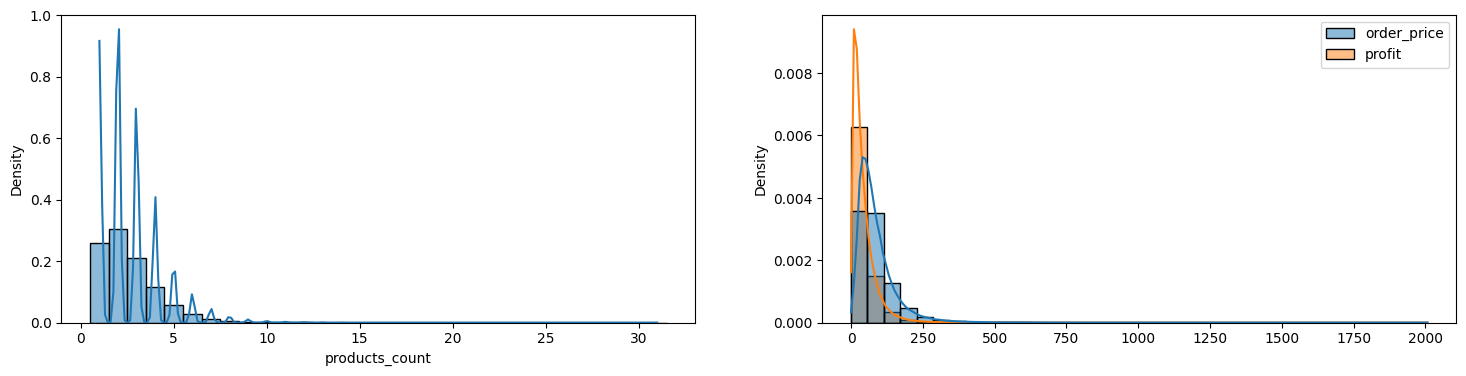

In [14]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(orders["products_count"], stat='density', 
			 kde=True, bins=orders.products_count.max(), discrete=True,
             ax=axes[0])
sns.histplot(orders[["order_price","profit"]], 
             stat='density', 
			 kde=True,
             bins=35,
             ax=axes[1])

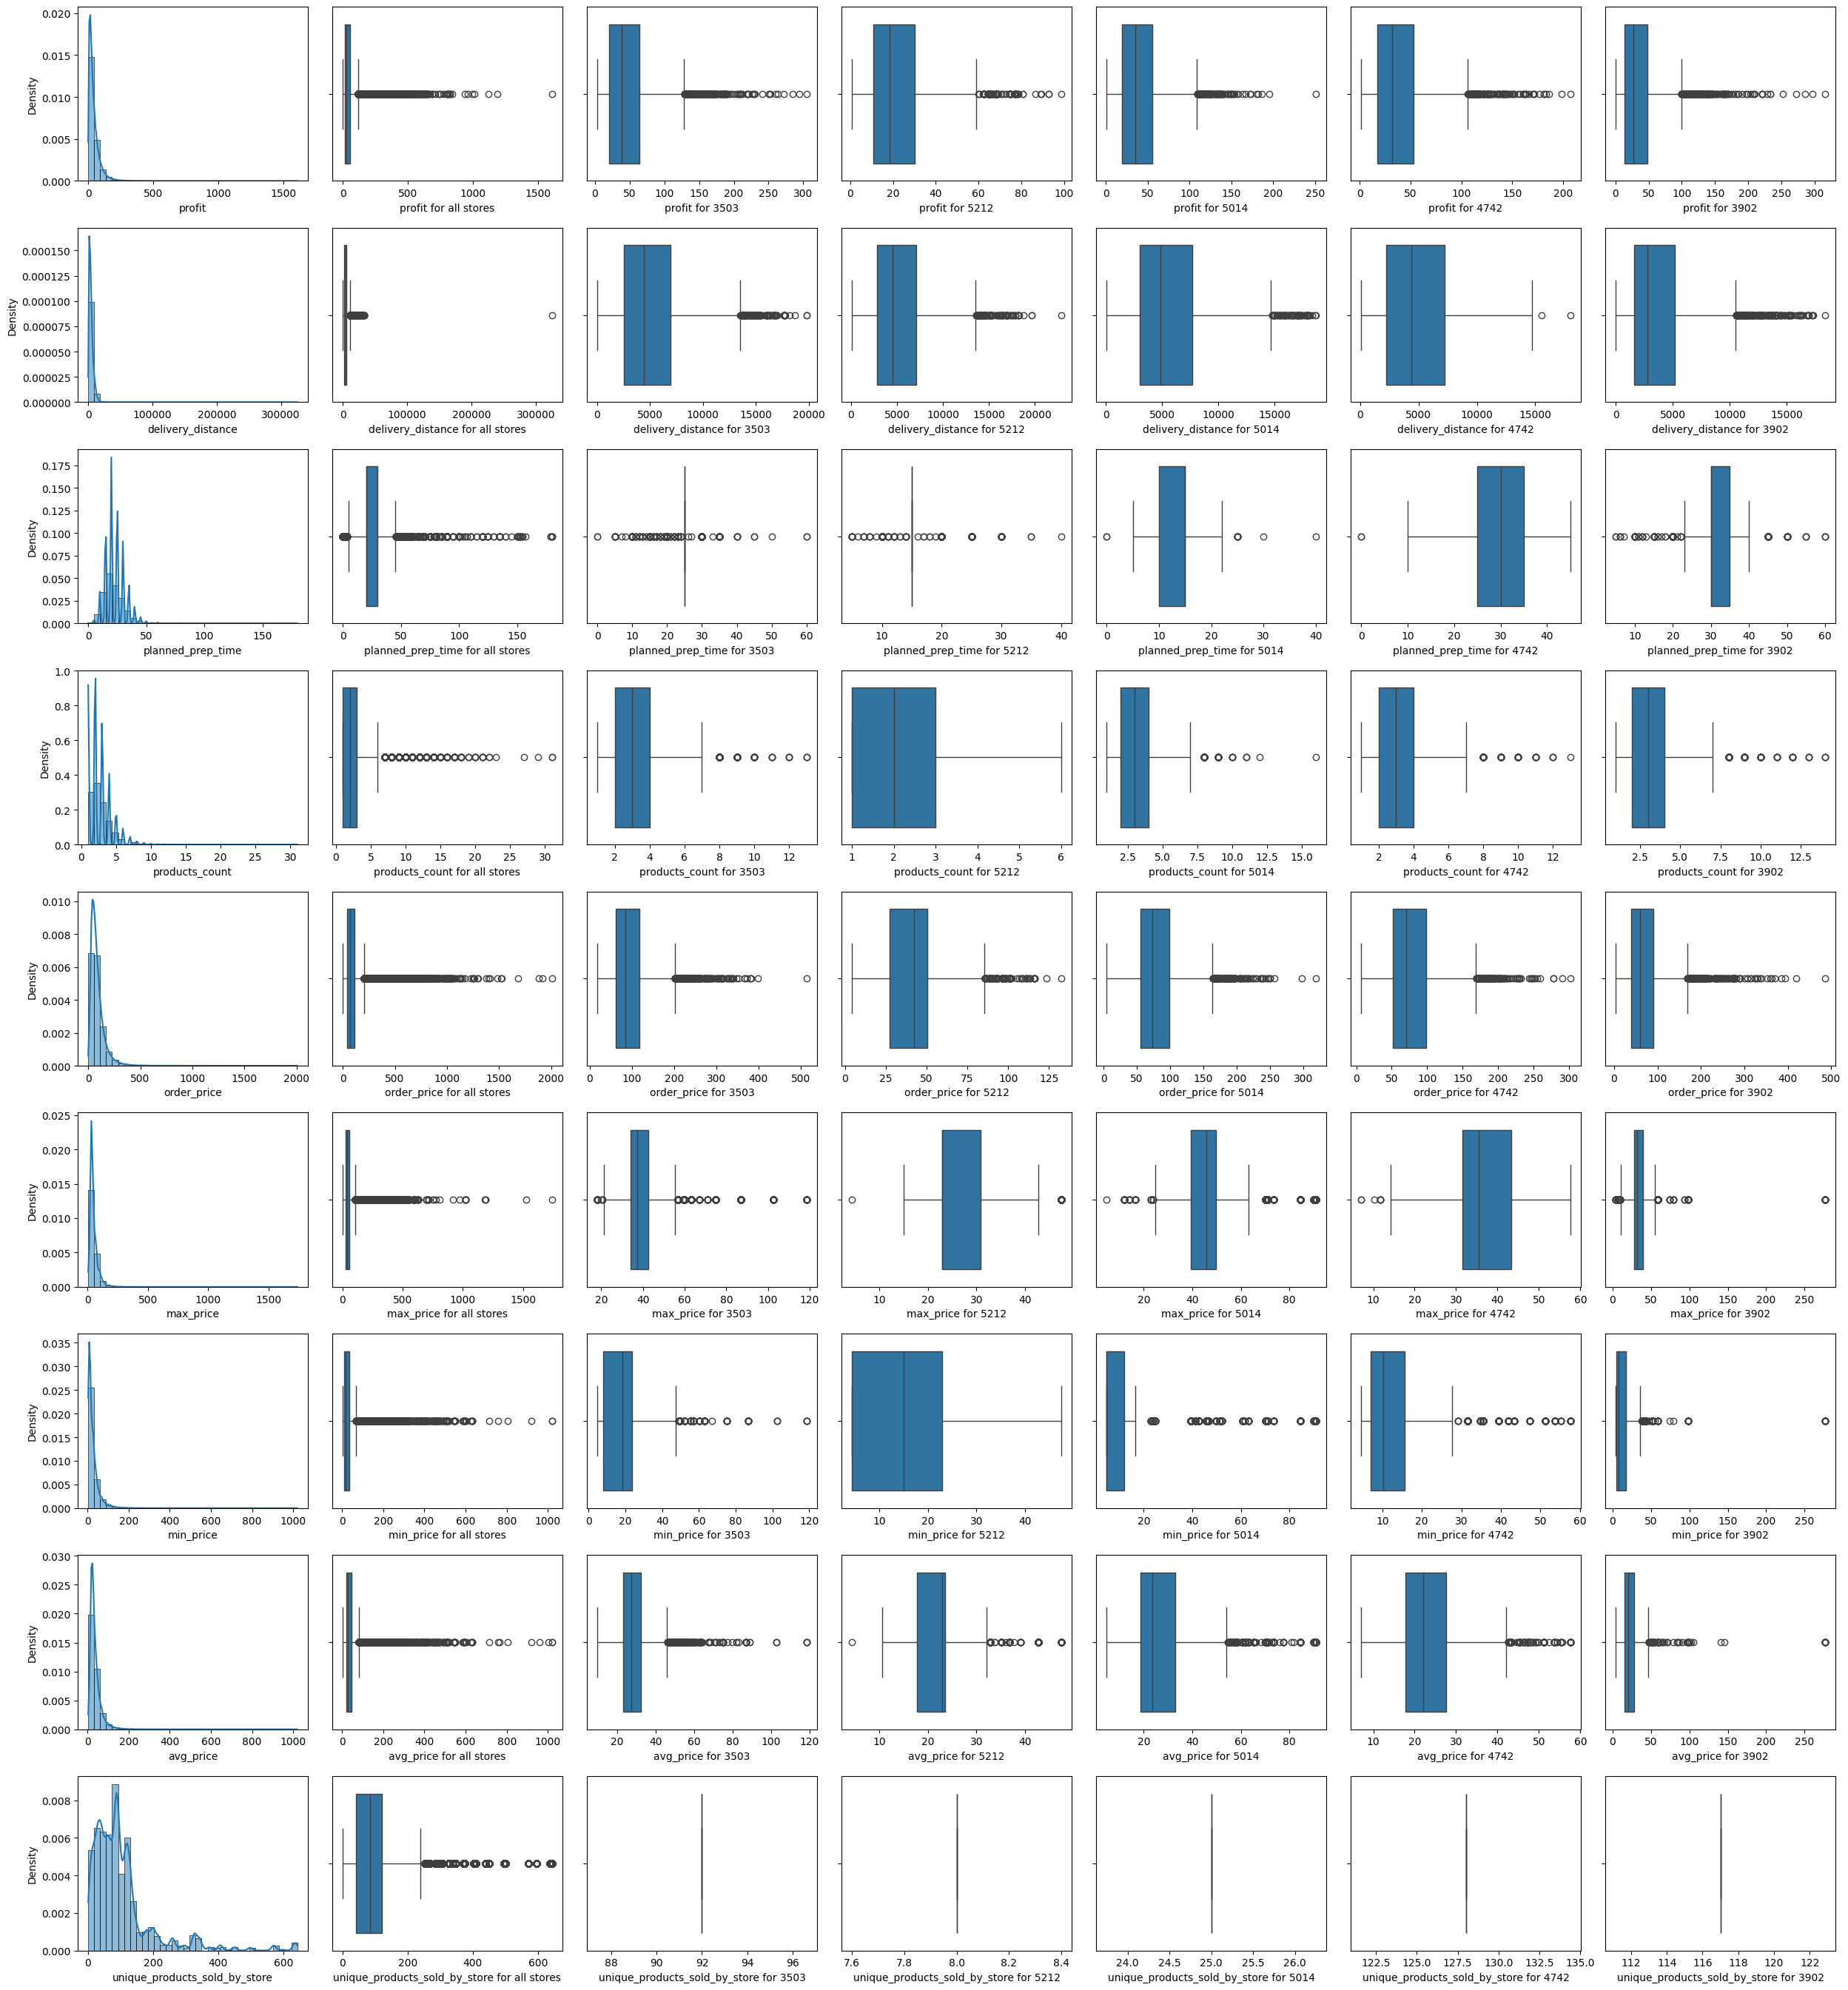

In [15]:
numerical = orders.select_dtypes('number')
boxplots_top_stores(orders, numerical.columns)

### Categorical and binary features

<Axes: title={'center': 'status_id'}, xlabel='status_id'>

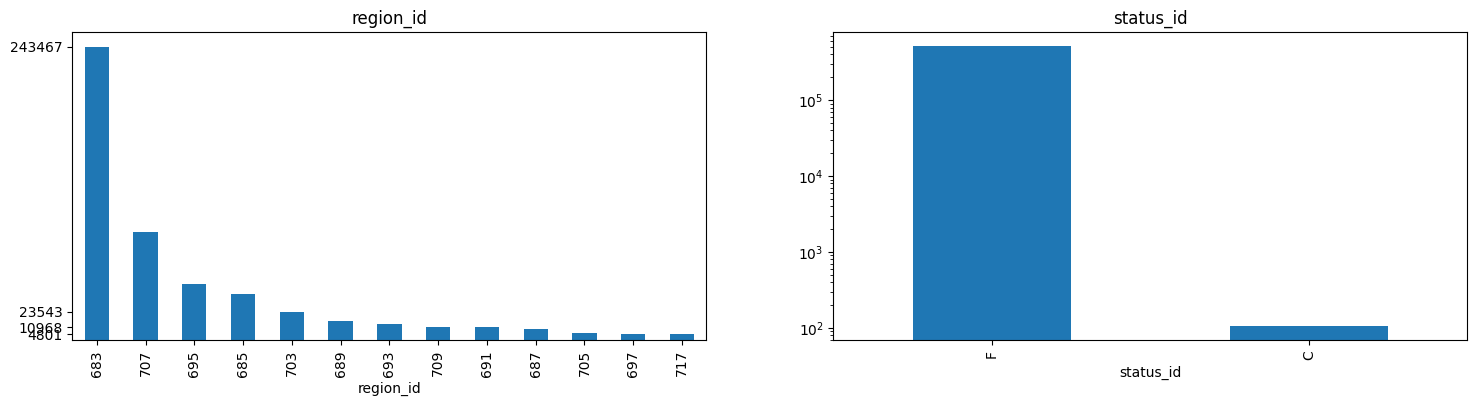

In [16]:
_, axes = plt.subplots(1,2, figsize=(18,4))
orders['region_id'].value_counts().plot(kind='bar',
                                        yticks=orders['region_id'].value_counts().values[::4],
                                        title='region_id',
                                        ax=axes[0])
orders['status_id'].value_counts().plot(kind='bar', logy=True, title='status_id', ax=axes[1])


In [17]:
orders['store_id'].value_counts()

store_id
3503     10173
5212      7433
5014      5998
4742      5185
3902      5145
         ...  
10593        1
11519        1
11825        1
10137        1
6747         1
Name: count, Length: 1419, dtype: int64

### Multi-dimentional analysis

<Axes: >

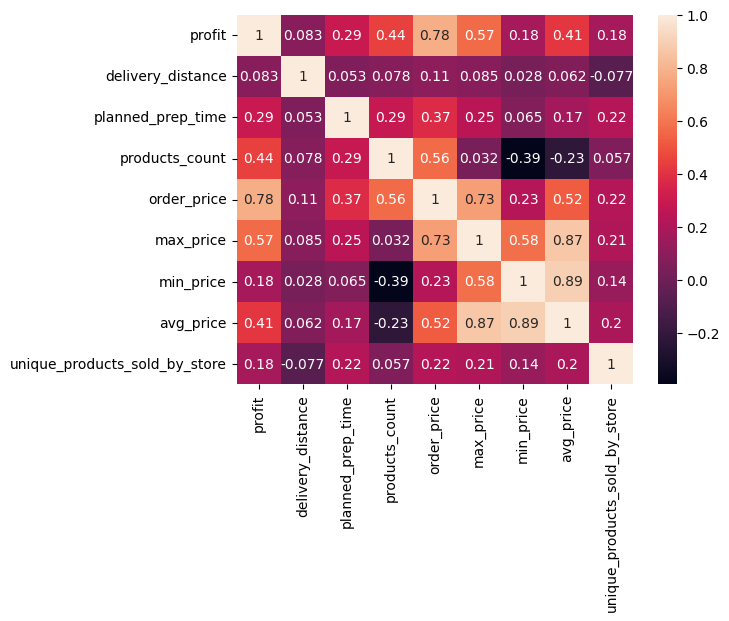

In [18]:
corr_matrix = orders.select_dtypes('number').corr()
sns.heatmap(corr_matrix, annot=True)

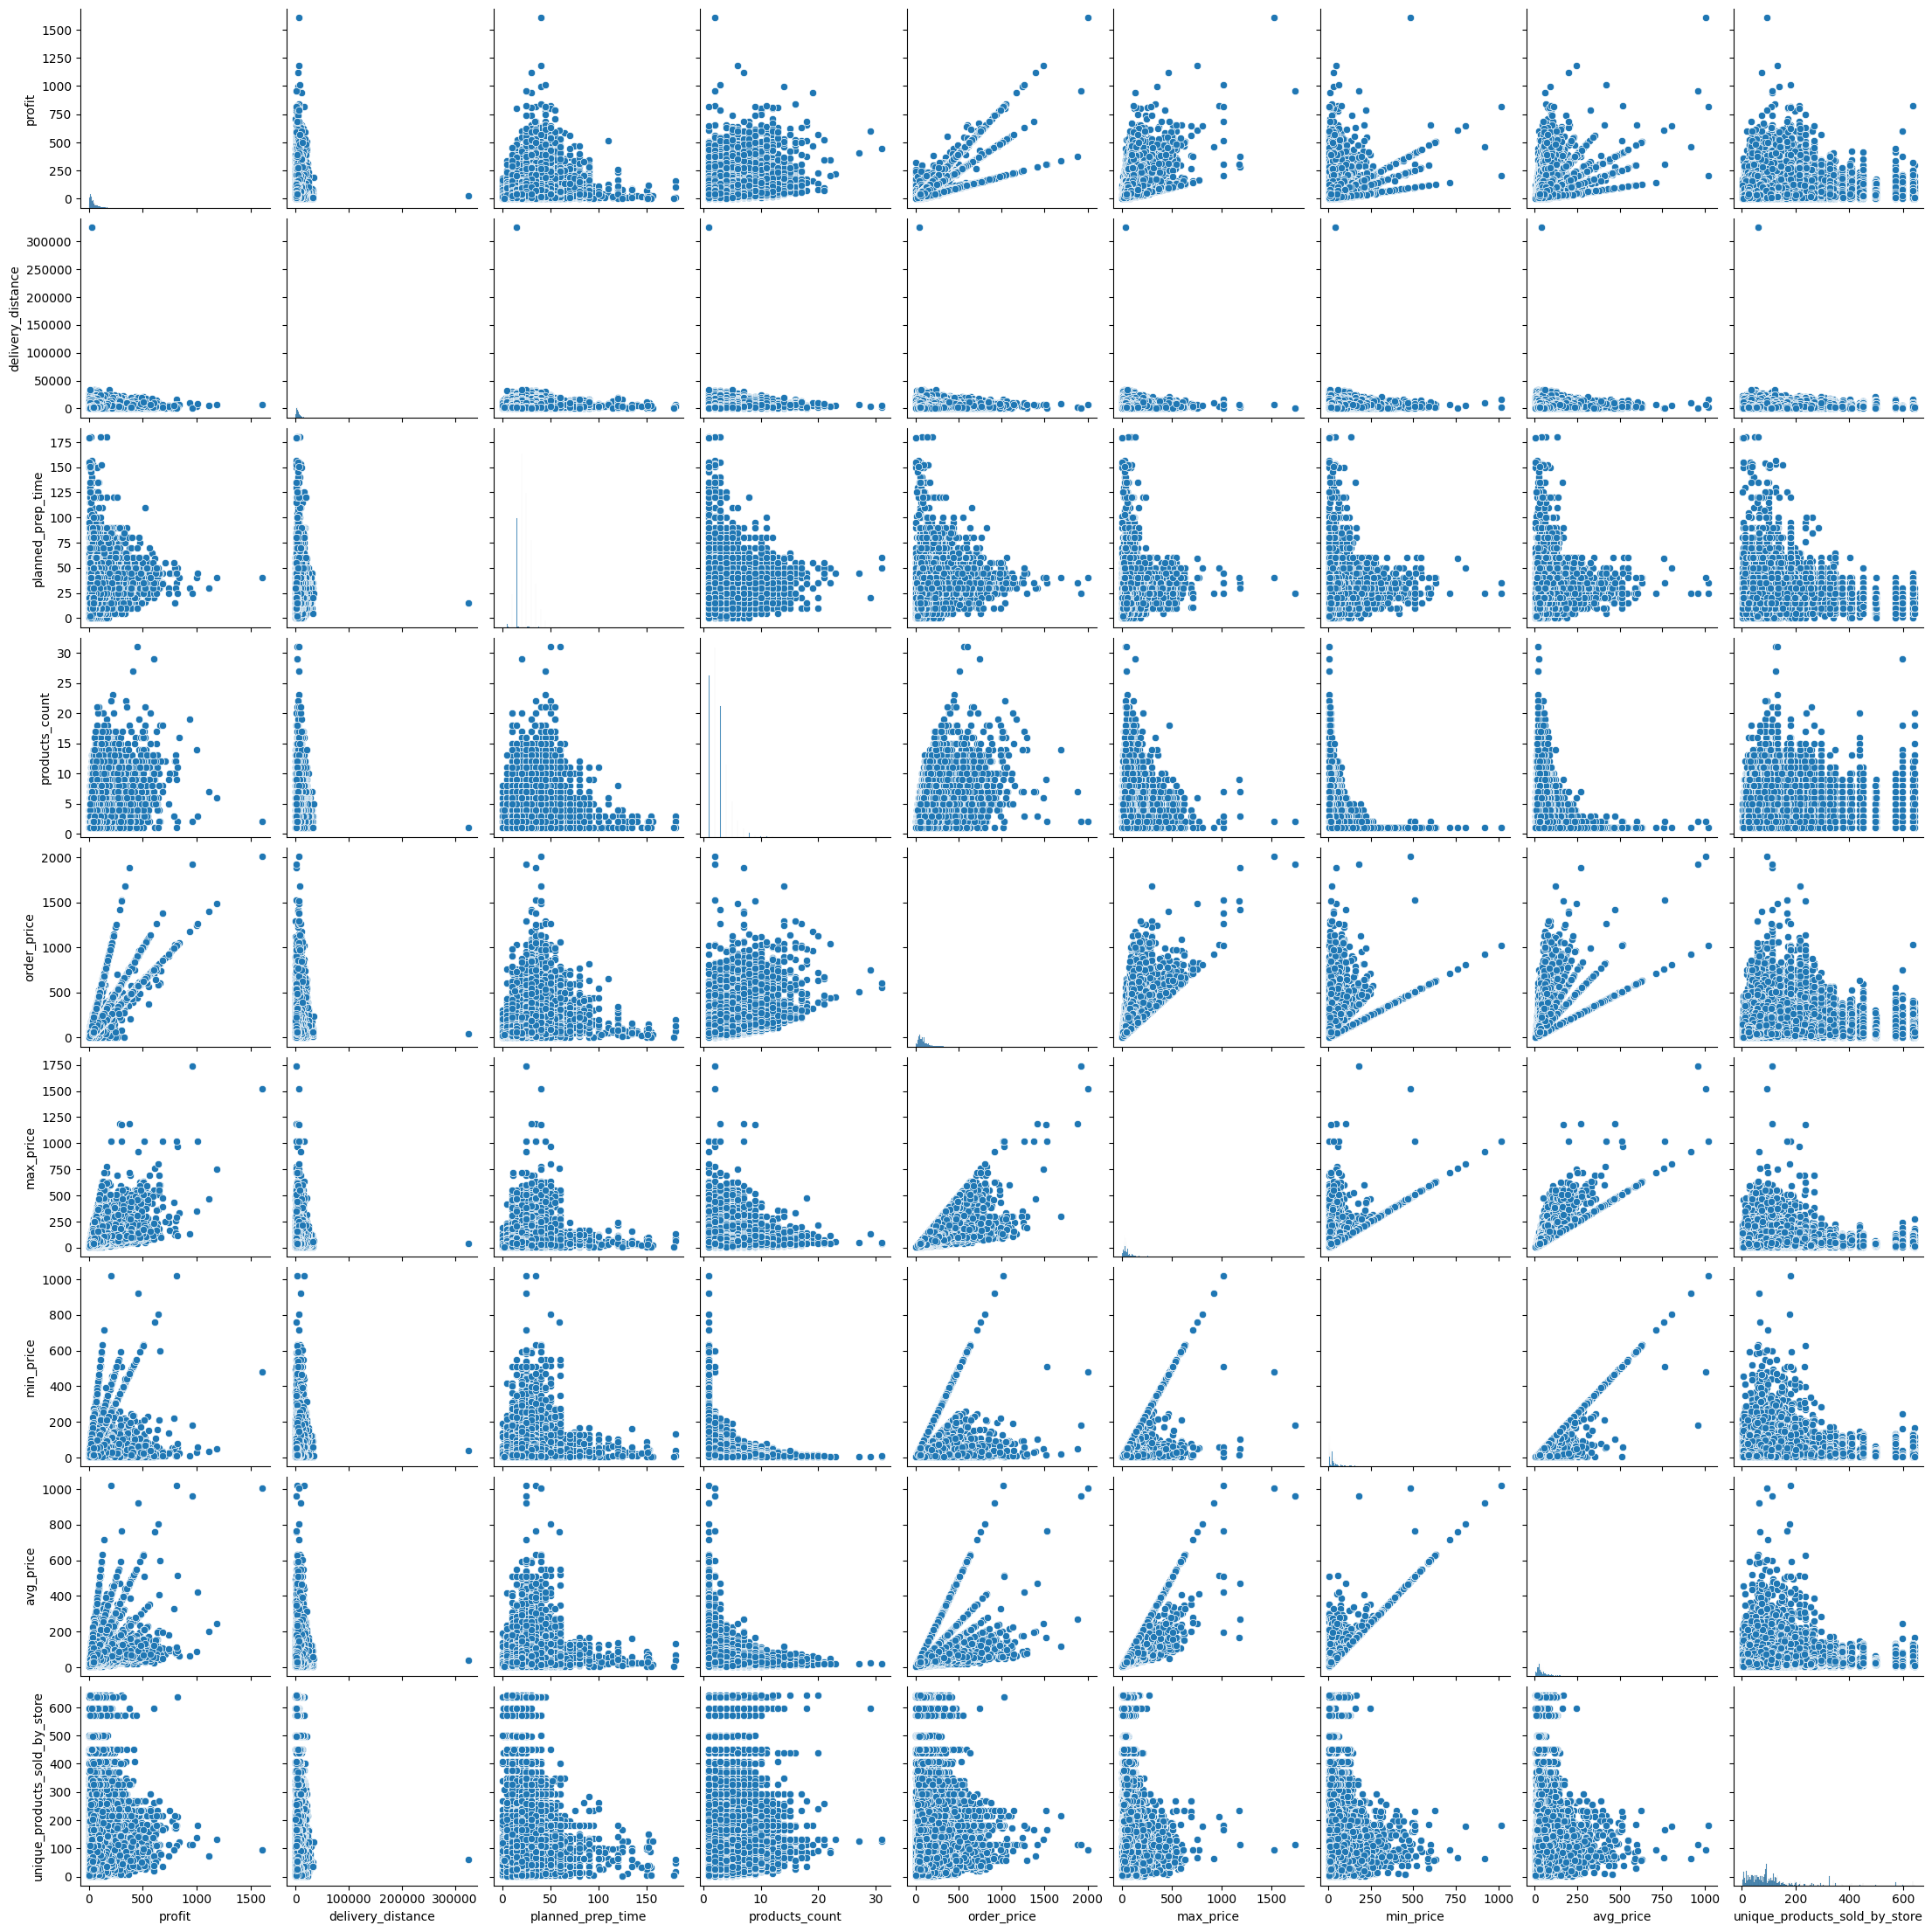

In [19]:
%config InlineBackend.figure_format = 'png'
sns.pairplot(orders.select_dtypes('number'))

## Preprocess the data

In [42]:
orders_without_outls = sort_dates(orders.copy(), date_columns)
# orders_without_outls = orders.copy()

Shape before removing outliers:  (517610, 16)
Shape after removing outliers:  (390124, 16)


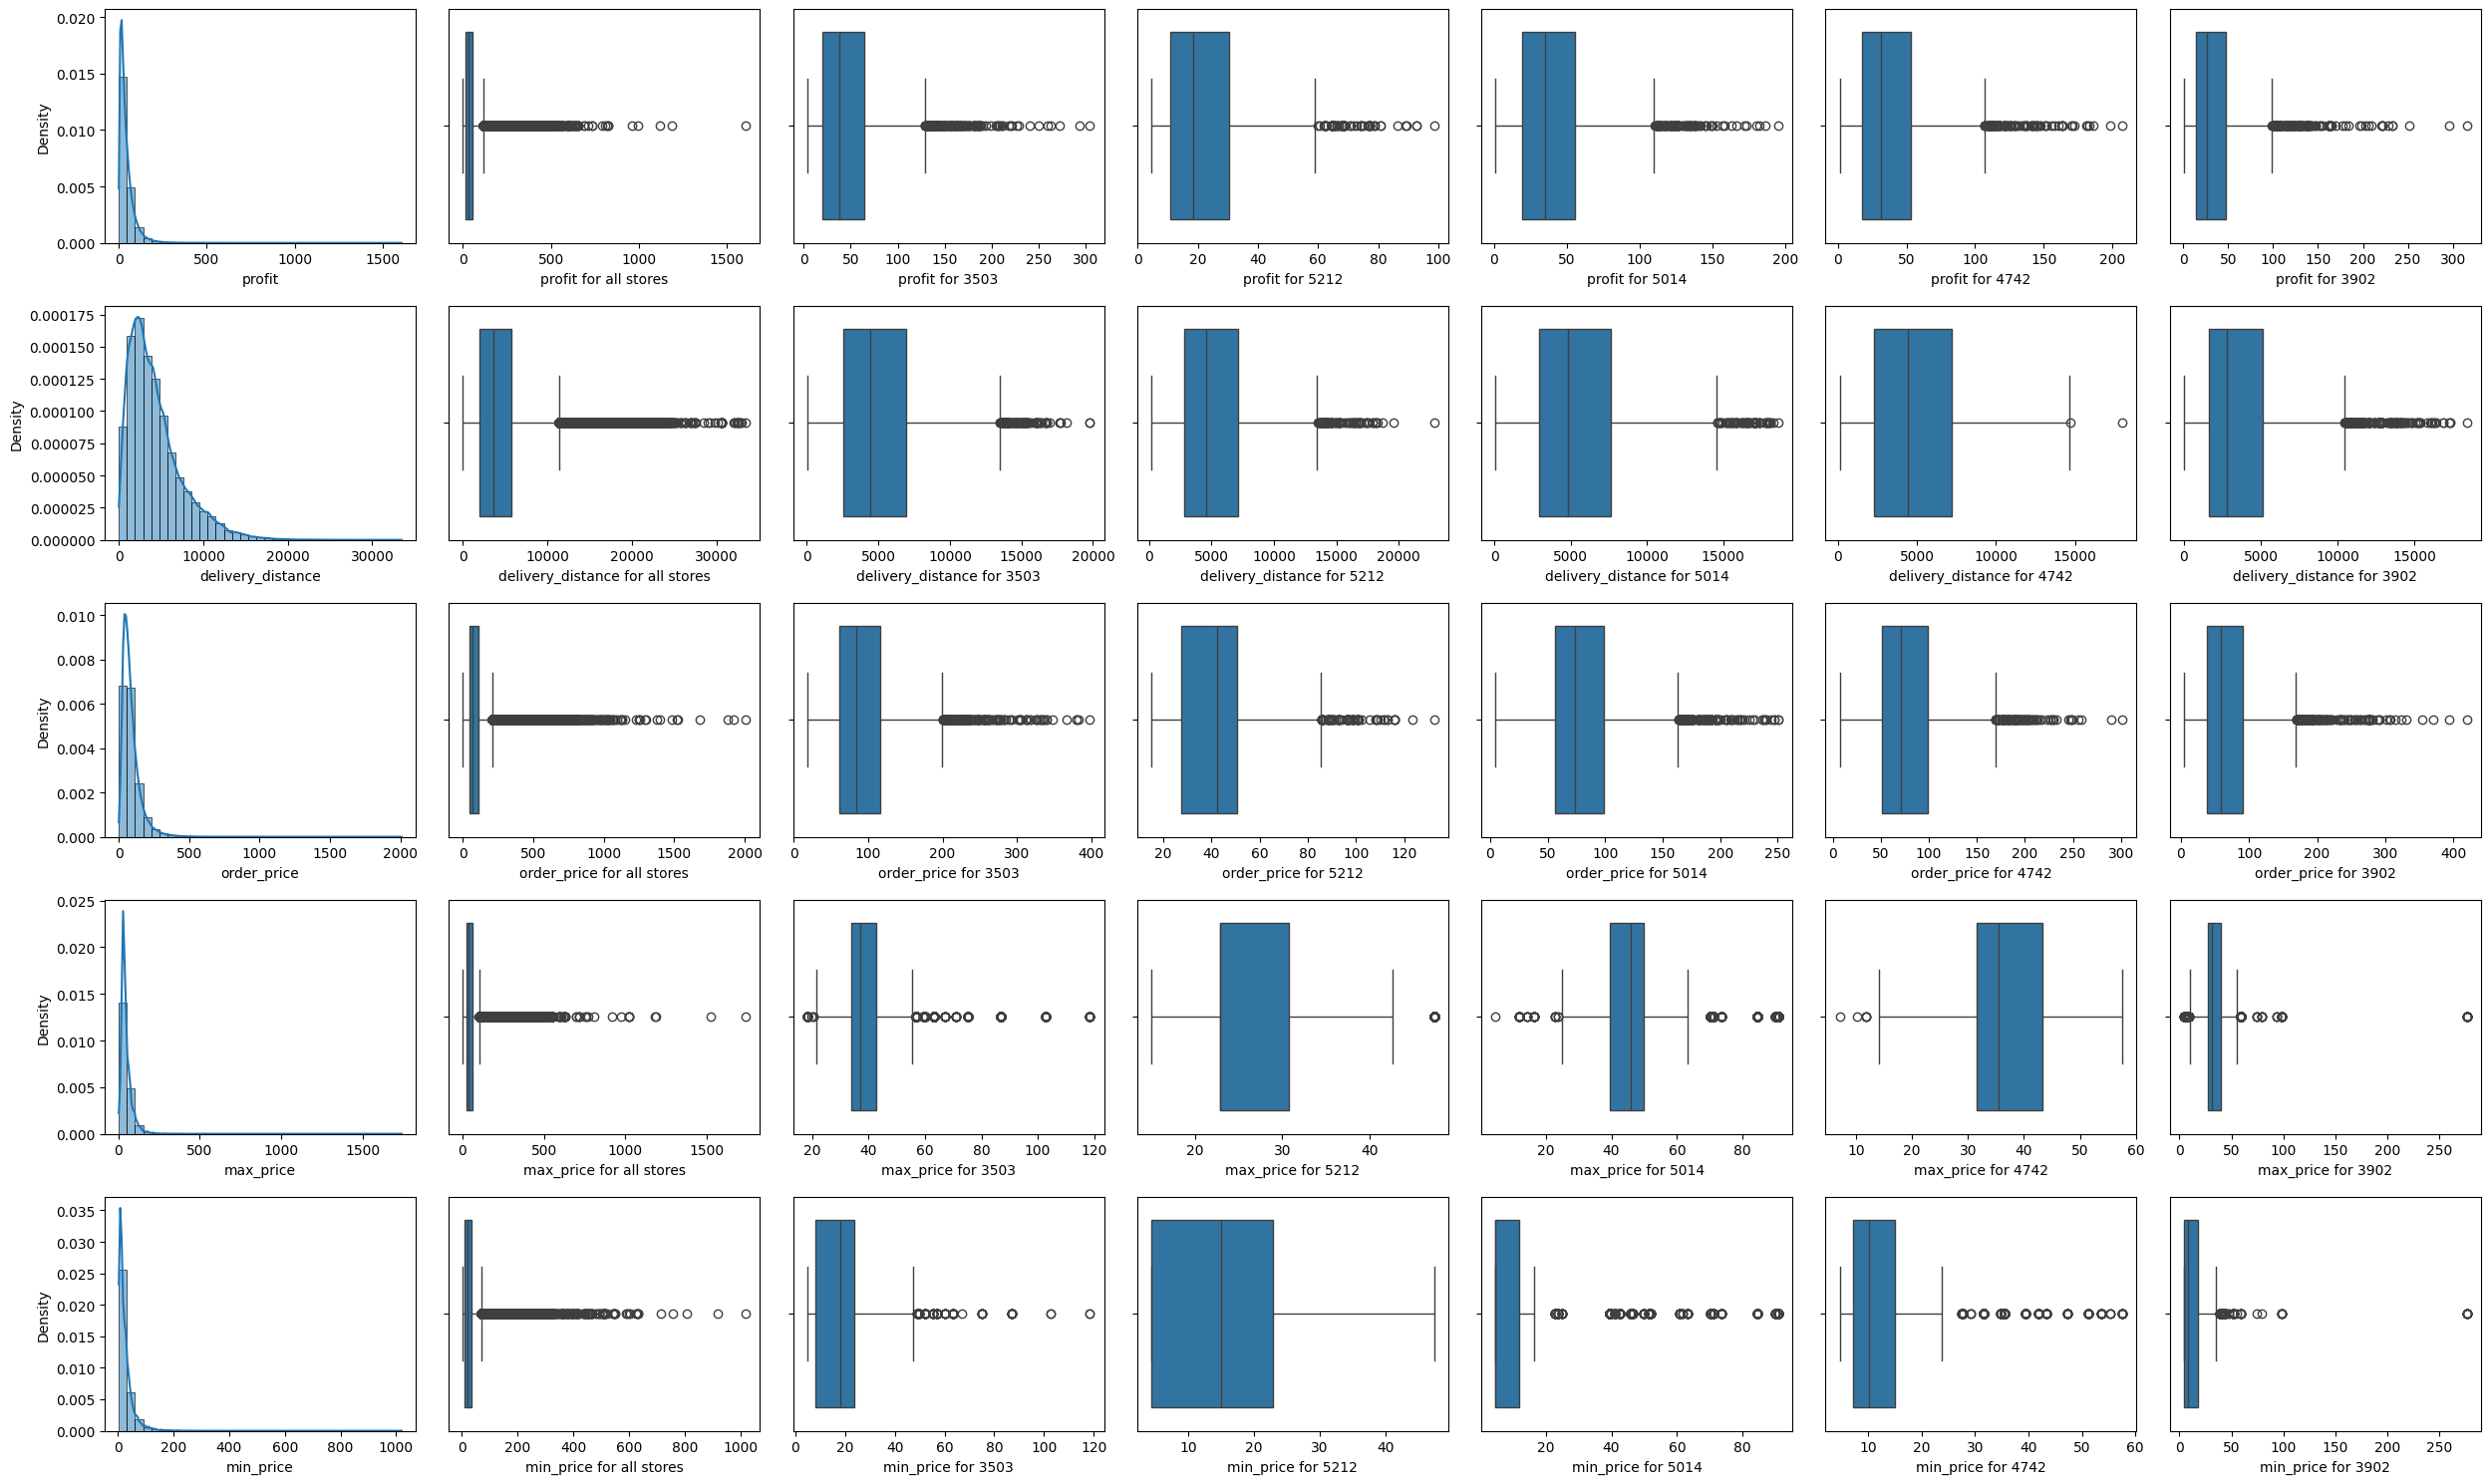

In [45]:
features_for_rm_outls = ['profit', 'delivery_distance','order_price','max_price','min_price']
quantiles = np.array([[0.0, 0.95],
                      [0.0, 0.95],
                      [0.0, 0.95],
                      [0.0, 0.95],
                      [0.0, 0.95]])
rmvd_outliers = rm_outliers(orders_without_outls.copy(), features_for_rm_outls, quantiles)
boxplots_top_stores(rmvd_outliers, features_for_rm_outls)

<Axes: >

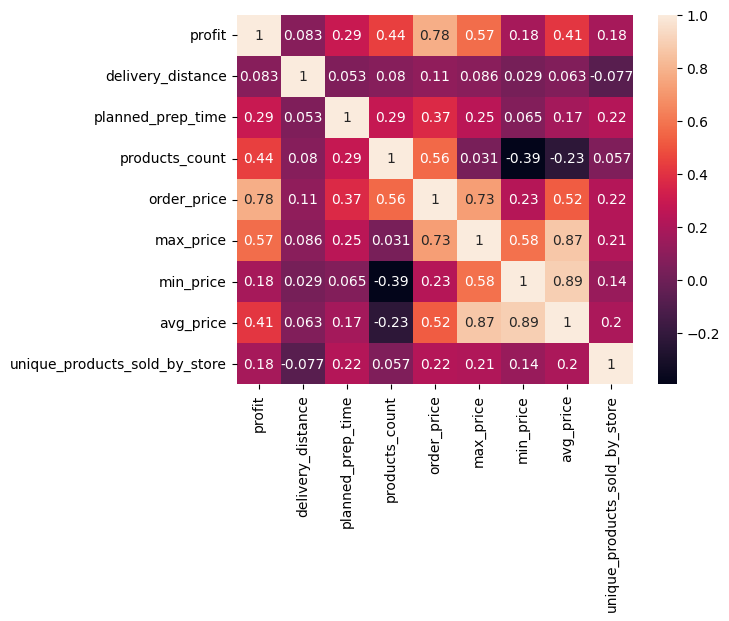

In [46]:
corr_matrix = rmvd_outliers.select_dtypes('number').corr()
sns.heatmap(corr_matrix, annot=True)

sns.relplot(rmvd_outliers, 
            kind="scatter",
            x='order_price', y='profit', 
            size='delivery_distance', sizes=(20, 200),
            col="products_count")

In [47]:
selected_features = ['store_id', 'profit', 'delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
df_selected_feats = rmvd_outliers[selected_features]

In [48]:
X_train, X_test = train_test_split(df_selected_feats, train_size=0.9, shuffle=False)

In [49]:
X_train = impute_df(X_train)
X_test = impute_df(X_test)

In [50]:
X_train, y_train = extract_target(X_train)
X_test, y_test = extract_target(X_test)
data_features = ['date_create','order_start_prepare']

Nan's in actual_prep_time:  25 
Negatives:  1465 
Outliers in time difference:  35033
All anomalyes:  36504
Nan's in actual_prep_time:  16 
Negatives:  162 
Outliers in time difference:  3900
All anomalyes:  4076


<Axes: ylabel='actual_prep_time'>

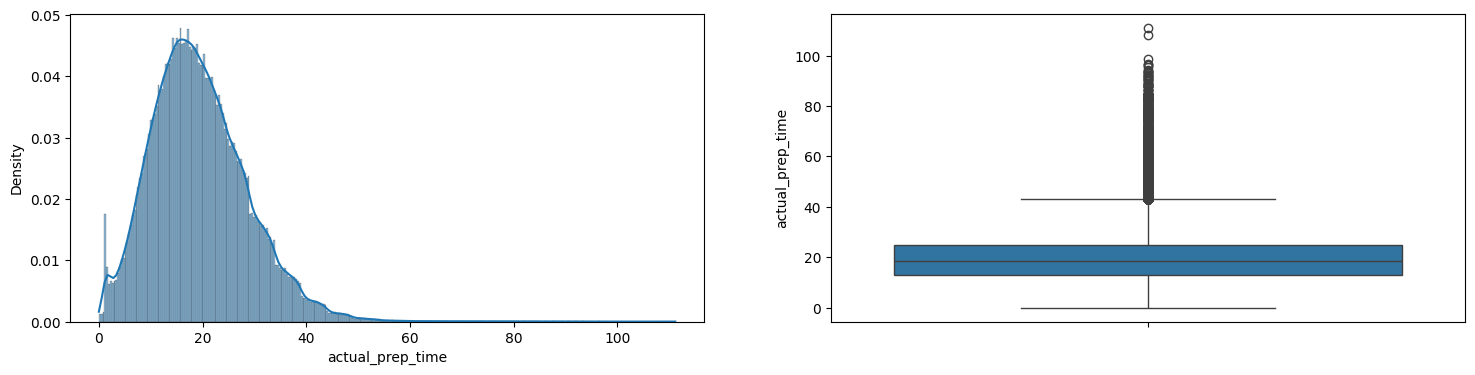

In [51]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(y_train, 
             stat='density', 
			 kde=True,
            #  bins=35
            ax=axes[0]
             )
sns.boxplot(data=y_train, ax=axes[1])

In [52]:
X_train = extract_date_feat(X_train, data_features)
X_test = extract_date_feat(X_test, data_features)
X_train.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'products_count', 'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos'],
      dtype='object')

In [53]:
na_columns_train = X_train.columns[X_train.isna().any()]
print(na_columns_train)
na_columns_test = X_test.columns[X_test.isna().any()]
print(na_columns_test)

Index(['profit', 'max_price', 'min_price'], dtype='object')
Index(['profit', 'max_price', 'min_price'], dtype='object')


In [54]:
X_train.loc[:,na_columns_train] = X_train.groupby("store_id")[na_columns_train].transform(lambda x: x.fillna(x.median()))
X_test.loc[:,na_columns_test] = X_test.groupby("store_id")[na_columns_test].transform(lambda x: x.fillna(x.median()))

In [55]:
# ###################################### Imputting #####################################
from sklearn.impute import SimpleImputer
col_imputing = X_test.columns[X_test.isna().any()].union(X_train.columns[X_train.isna().any()])
print(col_imputing)

imputer = SimpleImputer(strategy='median')
X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), columns=col_imputing, index=X_train.index)
X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), columns=col_imputing, index=X_test.index)

Index(['max_price', 'min_price', 'profit'], dtype='object')


In [56]:
###################################### Encoding #####################################
cat_features = X_train.select_dtypes('object').columns
encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

In [57]:
##################################### Scaling #####################################
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

## Models

In [60]:
estimators = []

### Experiment #1

##### LOGS
1. Standard, without outliers:

- Model intercept : 21.04388444324813
- Model coefficient : [ 5.52457146  0.03264817  0.85978668 -0.39949504  0.06497981  1.14025376
  1.23424433 -0.30113213 -0.15648194  0.47816519 -0.15326178  2.12079879
  5.63445821 -4.96575231 -1.16043827  0.09581642  0.37884022 -0.77774688
  6.08308759 -0.22958013  0.05987241 -2.09961301 -5.59480099  4.92868972
  1.16291024 -0.18931857 -0.45168904  0.92046575 -6.29359033  0.25323359
 -0.06398044]
- Mean Absolute Error: 6.665920038056755
- Mean Squared Error: 80.88280444459944
- Root Mean Squared Error: 8.99348677903067
- R^2: 0.2895531043061308
- [0.30691999 0.30898236 0.28459409 0.31395973 0.32878649 0.33794445
 0.30117314 0.31803191 0.31956174 0.33214268]

2. MinMax Scaler, without outliers:

- Model intercept : 1.3712186074908104
- Model coefficient : [102.66021252   0.21141436   4.36950465  -5.35861636  11.98342526
   5.64303251   8.12072922  -2.00759788  -0.93860961   3.08145893
  -0.995516     6.00321974  15.15466264 -13.89831233  -3.3377088
   0.25141261   1.01987738  -3.27090446  16.01354612  -0.6534127
   0.16816399  -5.94310041 -15.04805538  13.79461526   3.34480826
  -0.49676613  -1.21599042   3.88057743 -16.57055683   0.72082826
  -0.17967125]
- Mean Absolute Error: 6.665920038056754
- Mean Squared Error: 80.88280444459942
- Root Mean Squared Error: 8.993486779030668
- R^2: 0.289553104306131
- [0.30691999 0.30898236 0.28459409 0.31395973 0.32878649 0.33794445
 0.30117314 0.31803191 0.31956174 0.33214268]

 3. MinMax Scaler, with outliers:

- Model intercept : 1.533295500648972
- Model coefficient : [102.16912908   0.51699814  90.56447793  -5.68369878  13.4901932
  27.41855987  33.57531751 -13.06723746 -10.31361113  27.13572802
  -0.64668568   5.17596063  18.88593849 -11.18225755  -4.45147494
   0.92542868   1.31158712  -2.96720218  16.64405757  -0.71342786
   0.18598803  -5.09094565 -18.81577304  11.0865429    4.44063323
  -1.17991665  -1.49134523   3.59324426 -17.26875809   0.75936864
  -0.20168221]
- Mean Absolute Error: 6.841625042439062
- Mean Squared Error: 86.39150000730311
- Root Mean Squared Error: 9.294702792844056
- R^2: 0.30582619411149325
- [0.32596063 0.33034822 0.30366734 0.32512623 0.3385913  0.35454481
 0.31798212 0.3347442  0.33507521 0.34562636]

 4. Sorted Dates, MinMax Scaler, without outliers:

- Model intercept : 21.014066570286836
- Model coefficient : [ 5.51934445  0.03367108  0.85784051 -0.39715066  0.02044818  1.14038476
  1.22938848 -0.30042631 -0.15553284  0.4799959  -0.15228843  2.09421193
  5.29790384 -5.2336083  -1.95389777  0.1705795   0.32475247 -0.78221142
  6.39219117 -0.21462327  0.04514492 -2.08367586 -5.27100484  5.20266614
  1.95799082 -0.26620811 -0.39721835  0.92183602 -6.60804352  0.24153522
 -0.0470196 ]
- Mean Absolute Error: 6.689114394521547
- Mean Squared Error: 81.2856168118873
- Root Mean Squared Error: 9.015853637448163
- R^2: 0.2886331776444391
- [0.30632133 0.3077467  0.28381716 0.31296568 0.32752355 0.33132165
 0.30001487 0.31696031 0.31803555 0.33177156]

 5. Sorted dates, without outliers by store, in diff_time (betw planned- & actual_prep_time) (+ drop outliers in test subset), CatboostEncoder, MixMax Scaler:

- Model intercept : -1.4110701685687523
- Model coefficient : [ 2.29866368e+01 -4.18940022e-02  2.55617643e+00  1.09285893e+02
 -2.06642140e+00  1.08998621e+01  1.17595844e+01  4.81192012e+00
  2.36630291e+00 -5.22820485e-01  2.22740917e+00  1.56766931e+01
 -1.69474489e+00 -3.89724499e+00  1.51382940e+00  2.20357842e+00
 -1.86395425e+00  8.46025627e+00 -3.49493134e-01  1.98348487e-01
 -2.11619422e+00 -1.57189559e+01  1.68422988e+00  3.87817649e+00
 -1.52354419e+00 -2.23554629e+00  2.54424279e+00 -8.46060215e+00
  3.97733046e-01 -1.96325613e-01]
- Mean Absolute Error: 4.895355806454875
- Mean Squared Error: 37.74919475722025
- Root Mean Squared Error: 6.1440373336447305
- R^2: 0.5437851731596179
- Cross validate:  [0.55830879 0.50799238 0.56187023 0.56588657 0.55093078 0.53615044
 0.54616264 0.55041935 0.55510287 0.54380219]

 6. Non-Sorted dates (will be teleted by diff_time), without outliers by store, in diff_time (betw planned- & actual_prep_time) (+ drop outliers in test subset), CatboostEncoder, MixMax Scaler:
- Model intercept : -0.9996070302768558
- Model coefficient : [ 22.68391149  -0.13131328   2.55743655 108.9174117   -2.09072987
  10.68582708  12.13429285   4.65584923   2.17244919  -0.54704399
   2.27588024  15.46979568  -1.18815434  -2.4569088    1.54844143
   2.27506697  -1.81429026   7.91861919  -0.34631364   0.19176208
  -2.1672897  -15.50752272   1.17759871   2.43681781  -1.56174285
  -2.31650825   2.51165402  -7.92516532   0.40251537  -0.19707267]
- Mean Absolute Error: 4.879627747880329
- Mean Squared Error: 37.489562400124896
- Root Mean Squared Error: 6.122872071187254
- R^2: 0.5446371956579572
- Cross validate:  [0.55745107 0.50637449 0.56221564 0.56660501 0.55099006 0.53721079
 0.54805233 0.5516625  0.55513495 0.54466033]

Model intercept : -0.9818299280088887
Model coefficient : [ 22.70448589  -0.15790064   2.53208926 108.60439711  -2.03957876
  10.62796425  12.31506495   4.45906949   2.09394868  -0.53744375
   3.65395428  15.37262286   0.18224826  -1.58584949   1.75296125
   2.87212923  -1.93245681   7.76505309  -0.3434654    0.17789838
  -3.55321208 -15.4021991   -0.21632686   1.56074681  -1.76969839
  -2.90927127   2.63119482  -7.77969324   0.39877802  -0.18854565]
- Mean Absolute Error: 4.877347962044272
- Mean Squared Error: 37.441341956450046
- Root Mean Squared Error: 6.118933073375623
- R^2: 0.5455052417441164


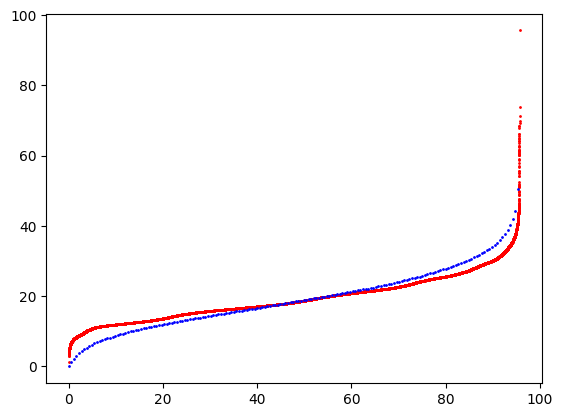

In [61]:
############################## Linear Regression ############################## 
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(f"Model intercept : {regressor.intercept_}")
print(f"Model coefficient : {regressor.coef_}")
scores(regressor, X_test, y_test, X_train, y_train)
estimators.append(("Linear Regression", regressor, X_test, y_test))

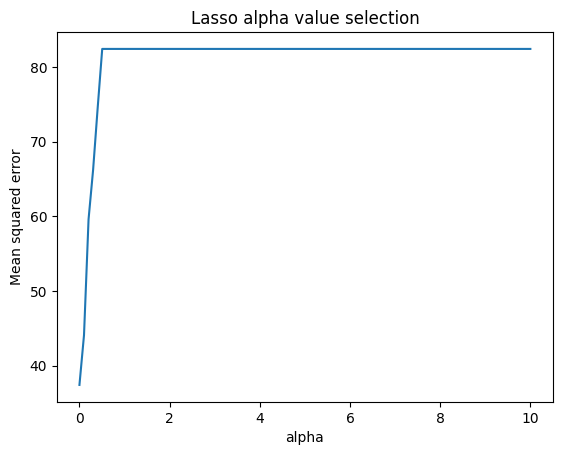

Best value of alpha: 0.0


In [62]:
################################## Lasso ################################## 
alphas = np.linspace(0e-2, 10, 100)
losses = []
for alpha in alphas:
    lasso = Lasso(alpha, random_state=42)
    lasso.fit(X_train, y_train)
    losses.append(metrics.mean_squared_error(y_test, lasso.predict(X_test)))

plt.plot(alphas, losses)
plt.title("Lasso alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

- Mean Absolute Error: 4.877161549246194
- Mean Squared Error: 37.45956394172331
- Root Mean Squared Error: 6.1204218761228635
- R^2: 0.5452840478349519


unique_products_sold_by_store      0.417855
order_start_prepare_hour_cos       0.739670
order_start_prepare_hour_sin       0.741146
date_create_hour_cos               0.756992
region_id                          1.821528
delivery_distance                  2.421351
max_price                          3.273912
products_count                     9.390981
order_price                       13.312247
store_id                          22.606927
planned_prep_time                108.459003
dtype: float64

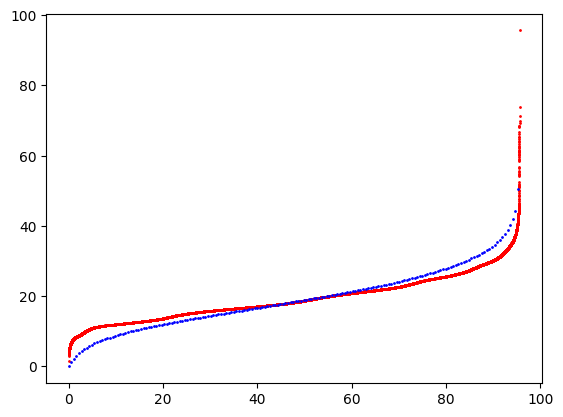

In [63]:
alpha = 0.001
lasso = Lasso(alpha, random_state=42)
lasso.fit(X_train, y_train)
estimators.append((f'Lasso regression (alpha={alpha})', lasso, X_test, y_test))
scores(lasso, X_test, y_test, X_train, y_train)

importance_features = abs(pd.Series(lasso.coef_, lasso.feature_names_in_)).sort_values()
importance_features = importance_features[importance_features > 0.1]
importance_features

### Experiment #2

In [64]:
X_train_reg = X_train[importance_features.index]
X_test_reg = X_test[importance_features.index]

Model intercept : -0.9871143613795326
unique_products_sold_by_store      0.530652
order_start_prepare_hour_sin       0.705912
region_id                          2.040814
delivery_distance                  2.518016
max_price                          5.389373
order_start_prepare_hour_cos       7.030394
date_create_hour_cos               7.037607
products_count                    10.071441
order_price                       12.430883
store_id                          22.713416
planned_prep_time                108.636325
dtype: float64 


- Mean Absolute Error: 4.876009220566184
- Mean Squared Error: 37.4333344720887
- Root Mean Squared Error: 6.118278718078207
- R^2: 0.5456024433794979


,Actual,Predicted
466017,4.966667,14.012197
466019,11.716667,16.492504
466020,25.533333,22.750497
466021,3.216667,15.014537
466022,29.016667,21.599681
...,...,...
517603,17.783333,13.225160
517604,3.383333,5.930543
517605,16.708333,11.888254
517607,14.900000,16.129665


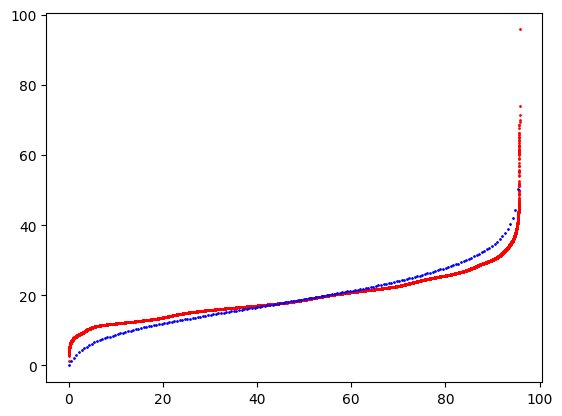

In [65]:
############################## Linear Regression ############################## 
regressor_drop_feats = LinearRegression()
regressor_drop_feats.fit(X_train_reg, y_train)
print(f"Model intercept : {regressor_drop_feats.intercept_}")
print(abs(pd.Series(regressor_drop_feats.coef_, regressor_drop_feats.feature_names_in_)).sort_values(), '\n\n')

scores(regressor_drop_feats, X_test_reg, y_test, X_train_reg, y_train)
# estimators.append((regressor_drop_feats, X_test_reg, y_test))

### PCA

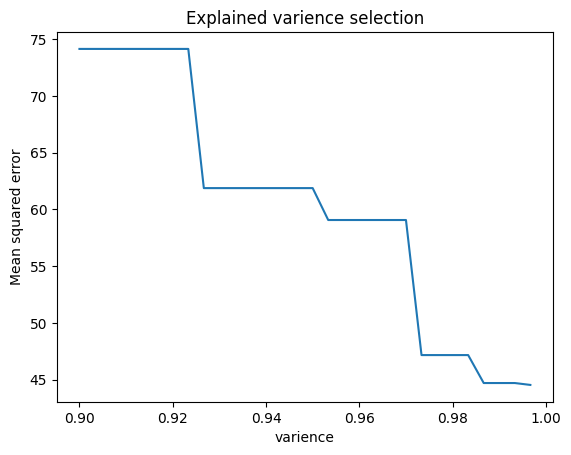

Best value of explained_variance: 0.9966666666666667


In [67]:
losses = []
explained_variances = np.linspace(0.9, 1, 30, endpoint=False)
for i in explained_variances:
    pca = PCA(n_components=i, random_state=42)
    X_train_pca = pca.fit_transform(X_train_reg)
    X_test_pca = pca.transform(X_test_reg)

    regressor2 = LinearRegression()
    regressor2.fit(X_train_pca, y_train)
    
    losses.append(metrics.mean_squared_error(y_test, regressor2.predict(X_test_pca)))
    

plt.plot(explained_variances, losses)
plt.title("Explained varience selection")
plt.xlabel("varience")
plt.ylabel("Mean squared error")
plt.show()
best_variance = explained_variances[np.argmin(losses)]
print("Best value of explained_variance:", best_variance)

Model intercept : -0.9818299280088887
Model coefs:  [ 22.70448589  -0.15790064   2.53208926 108.60439711  -2.03957876
  10.62796425  12.31506495   4.45906949   2.09394868  -0.53744375
   3.65395428  15.37262286   0.18224826  -1.58584949   1.75296125
   2.87212923  -1.93245681   7.76505309  -0.3434654    0.17789838
  -3.55321208 -15.4021991   -0.21632686   1.56074681  -1.76969839
  -2.90927127   2.63119482  -7.77969324   0.39877802  -0.18854565] 


- Mean Absolute Error: 5.2174246824589785
- Mean Squared Error: 44.53887573610437
- Root Mean Squared Error: 6.6737452555596075
- R^2: 0.4593493581449376


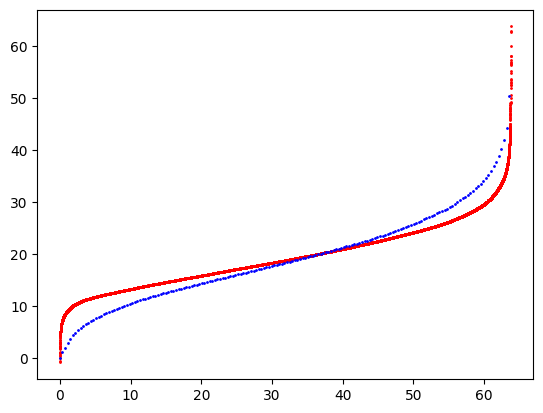

In [68]:
explained_variance = best_variance

pca = PCA(n_components=explained_variance)  
X_train_pca = pca.fit_transform(X_train_reg)
X_test_pca = pca.transform(X_test_reg)

regressor_pca = LinearRegression()
regressor_pca.fit(X_train_pca, y_train)
print(f"Model intercept : {regressor.intercept_}")
print("Model coefs: ", regressor.coef_, '\n\n')

scores(regressor_pca, pd.DataFrame(X_test_pca), y_test, 
                  pd.DataFrame(X_train_pca), y_train)
estimators.append(('Linear Regression with PCA_df (dropped by Lasso features)', regressor_pca, pd.DataFrame(X_test_pca), y_test))

### Ridge

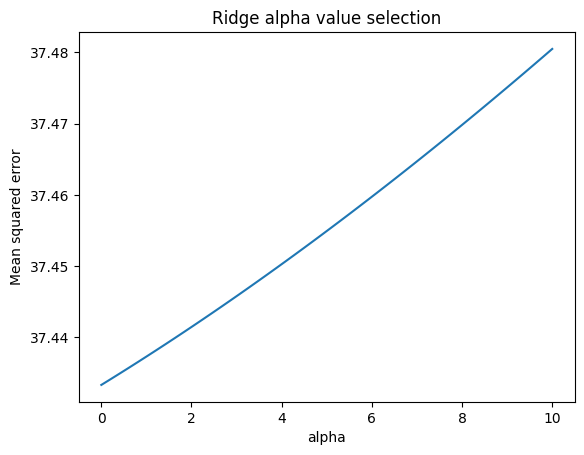

Best value of alpha: 0.001
- Mean Absolute Error: 4.876009479554693
- Mean Squared Error: 37.433338361680306
- Root Mean Squared Error: 6.118279035944692
- R^2: 0.5456023961643368


unique_products_sold_by_store      0.530650
order_start_prepare_hour_sin       0.705912
region_id                          2.040812
delivery_distance                  2.518018
max_price                          5.389405
order_start_prepare_hour_cos       7.030276
date_create_hour_cos               7.037488
products_count                    10.071492
order_price                       12.430880
store_id                          22.713515
planned_prep_time                108.636011
dtype: float64

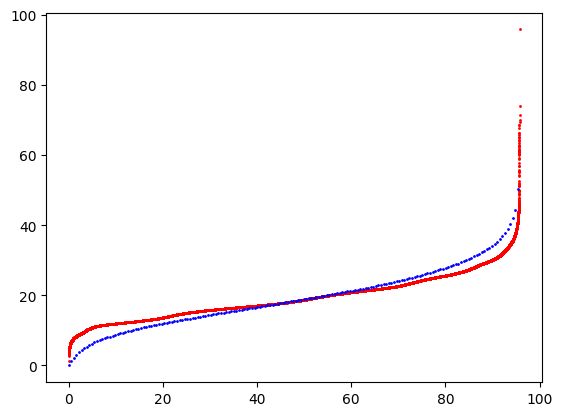

In [79]:
alphas = np.linspace(0.001, 10, 50)
losses = []
for alpha in alphas:
    ridge = Ridge(alpha, random_state=42)
    ridge.fit(X_train_reg, y_train)
    losses.append(metrics.mean_squared_error(y_test, ridge.predict(X_test_reg)))
   
    
plt.plot(alphas, losses)
plt.title("Ridge alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

alpha = best_alpha
ridge = Ridge(alpha, random_state=42)
ridge.fit(X_train_reg, y_train)

estimators.append(('Ridge regression (dropped by Lasso features)', ridge, X_test_reg, y_test))
scores(ridge, X_test_reg, y_test, 
              X_train_reg, y_train)
abs(pd.Series(ridge.coef_, ridge.feature_names_in_)).sort_values()

In [70]:
for desc, estimator, x, y in estimators:
    print('\t', desc)
    scores(estimator, x, y, plot=False)
    print('\n\n')

	 Linear Regression
- Mean Absolute Error: 4.877347962044272
- Mean Squared Error: 37.441341956450046
- Root Mean Squared Error: 6.118933073375623
- R^2: 0.5455052417441164



	 Lasso regression (alpha=0.001)
- Mean Absolute Error: 4.877161549246194
- Mean Squared Error: 37.45956394172331
- Root Mean Squared Error: 6.1204218761228635
- R^2: 0.5452840478349519



	 Linear Regression with PCA_df (dropped by Lasso features)
- Mean Absolute Error: 5.2174246824589785
- Mean Squared Error: 44.53887573610437
- Root Mean Squared Error: 6.6737452555596075
- R^2: 0.4593493581449376



	 Ridge regression (dropped by Lasso features)
- Mean Absolute Error: 4.876009479554693
- Mean Squared Error: 37.433338361680306
- Root Mean Squared Error: 6.118279035944692
- R^2: 0.5456023961643368





### Polynomial

1. StandardScaler, without outliers, catboostEncoder:
- features = ['unique_products_sold_by_store', 'order_start_prepare_hour_sin',
       'order_start_prepare_hour_cos', 'region_id', 'delivery_distance',
       'products_count', 'order_price', 'store_id']

- Principal components:  7
- Polynomial degree:  3
- Mean Absolute Error: 6.629615770644926
- Mean Squared Error: 80.39140632977117
- Root Mean Squared Error: 8.966125491524819
- R^2: 0.2938693773091111

2. Without outliers by store_id (+ in diff_time betw planned- actual_prep_time), with planned_prep_time,  
- Principal components:  8
- Polynomial degree:  2
- Mean Absolute Error: 5.996753009747382
- Mean Squared Error: 60.849468486492896
- Root Mean Squared Error: 7.800606930649236
- R^2: 0.4433796998740539
- Cross validate:  [0.46372499 0.46070269 0.4628072  0.47266049 0.46258839 0.45731497
 0.45352961 0.45884474 0.4575931  0.44336693]

In [80]:
degrees = [3]
n_components = range(len(X_train_reg.columns)-1, len(X_train_reg.columns)+1)
for i in degrees:
    for components in n_components:
        pca = PCA(n_components=components, random_state=42)
        X_train_poly = pca.fit_transform(X_train_reg)
        X_test_poly = pca.transform(X_test_reg)

        polynomial_features = PolynomialFeatures(degree=i)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                            ("linear_regression", linear_regression)])
        pipeline.fit(X_train_poly, y_train.to_frame())

        print("\n\nPrincipal components: ", components)
        print("Polynomial degree: ", i)
        scores(pipeline, pd.DataFrame(X_test_poly), y_test, 
               pd.DataFrame(X_train_poly), y_train, 10, False)




Principal components:  10
Polynomial degree:  3
- Mean Absolute Error: 4.823396565446162
- Mean Squared Error: 36.53377910279254
- Root Mean Squared Error: 6.044317918739264
- R^2: 0.5565220092588831
- Cross validate:  [0.57468253 0.56506435 0.56667147 0.56988098 0.56228325 0.54927068
 0.55538246 0.5666115  0.56181976 0.55669193]


Principal components:  11
Polynomial degree:  3
- Mean Absolute Error: 4.822348992840615
- Mean Squared Error: 36.51082980035293
- Root Mean Squared Error: 6.04241920097844
- R^2: 0.5568005873524933
- Cross validate:  [0.57496604 0.56502584 0.56679734 0.56997756 0.56203873 0.55162476
 0.5555085  0.5667582  0.56064568 0.55697557]


,Actual,Predicted
0,4.966667,14.736633
1,11.716667,12.042852
2,25.533333,23.069815
3,3.216667,12.301477
4,29.016667,22.377212
...,...,...
34929,17.783333,12.510921
34930,3.383333,7.192418
34931,16.708333,12.078245
34932,14.900000,15.613717


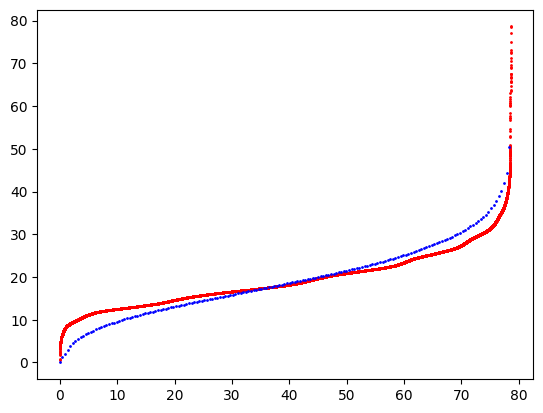

In [81]:
y_pred = pipeline.predict(X_test_poly)
eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')
eval_df

### Trees

- Mean Absolute Error: 4.849512960153432
- Mean Squared Error: 37.218877139486246
- Root Mean Squared Error: 6.100727590991606
- R^2: 0.54820570833861


,Actual,Predicted
466017,4.966667,13.062083
466019,11.716667,12.420250
466020,25.533333,25.364583
466021,3.216667,12.689167
466022,29.016667,23.630667
...,...,...
517603,17.783333,10.815500
517604,3.383333,6.181083
517605,16.708333,11.797167
517607,14.900000,16.508833


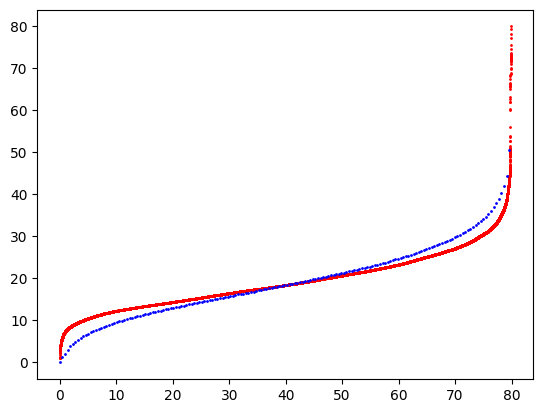

In [83]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest.fit(X_train_reg, y_train)

estimators.append(('Random fores', random_forest, X_test_reg, y_test))
scores(random_forest, X_test_reg, y_test, 
                      X_train_reg, y_train)

Learning rate set to 0.101583
0:	learn: 8.7551039	total: 78.8ms	remaining: 1m 18s
1:	learn: 8.3457097	total: 95.8ms	remaining: 47.8s
2:	learn: 7.9999804	total: 113ms	remaining: 37.5s
3:	learn: 7.7067218	total: 128ms	remaining: 31.9s
4:	learn: 7.4608820	total: 143ms	remaining: 28.5s
5:	learn: 7.2519079	total: 158ms	remaining: 26.2s
6:	learn: 7.0714666	total: 175ms	remaining: 24.8s
7:	learn: 6.9250857	total: 191ms	remaining: 23.6s
8:	learn: 6.8013068	total: 205ms	remaining: 22.5s
9:	learn: 6.6983291	total: 220ms	remaining: 21.8s
10:	learn: 6.6103304	total: 235ms	remaining: 21.1s
11:	learn: 6.5334048	total: 250ms	remaining: 20.6s
12:	learn: 6.4698627	total: 264ms	remaining: 20s
13:	learn: 6.4167930	total: 278ms	remaining: 19.6s
14:	learn: 6.3712413	total: 292ms	remaining: 19.2s
15:	learn: 6.3331520	total: 306ms	remaining: 18.8s
16:	learn: 6.3008451	total: 321ms	remaining: 18.6s
17:	learn: 6.2739003	total: 335ms	remaining: 18.3s
18:	learn: 6.2503679	total: 350ms	remaining: 18s
19:	learn: 6

,Actual,Predicted
466017,4.966667,12.897713
466019,11.716667,13.876147
466020,25.533333,23.390062
466021,3.216667,12.392976
466022,29.016667,23.179063
...,...,...
517603,17.783333,13.742281
517604,3.383333,6.447603
517605,16.708333,11.671786
517607,14.900000,15.577207


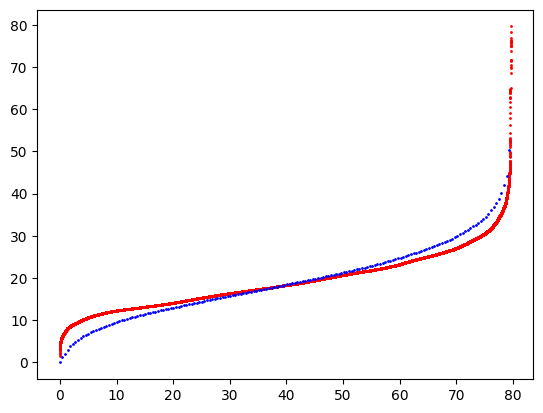

In [84]:
cat = CatBoostRegressor()
cat.fit(X_train_reg, y_train)

estimators.append(('CatBoost forest', cat, X_test_reg, y_test))
scores(cat, X_test_reg, y_test, 
                X_train_reg, y_train)

### Support vector regression

In [88]:
pca = PCA(n_components=8, random_state=42)
X_train_svr = pca.fit_transform(X_train_reg)
X_test_svr = pca.transform(X_test_reg)

number of support vectors for each class:  [1998] 


- Mean Absolute Error: 6.871765679657206
- Mean Squared Error: 77.59579240835232
- Root Mean Squared Error: 8.80884739386217
- R^2: 0.08953302485704917


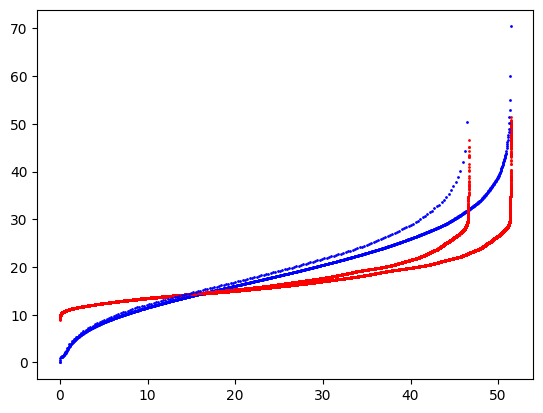

In [90]:
svr = SVR(kernel='rbf', degree=4, C=1, max_iter=1000)
svr.fit(X_train_svr, y_train)

# print("Support vectors: ", svr.support_vectors_) # get support vectors
# print("indices of support vectors: ", svr.support_) # get indices of support vectors
print("number of support vectors for each class: ", svr.n_support_,'\n\n') # get number of support vectors for each class

scores(svr, pd.DataFrame(X_train_svr), y_train, 
            pd.DataFrame(X_test_svr), y_test, False)

y_pred = svr.predict(X_test_svr)
eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

In [86]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = (torch.tensor(batch.values, dtype=torch.float32, device='cuda') 
                                                                for batch 
                                                                in (X_train, X_test, y_train, y_test))

type(X_train_tensor), X_train_tensor.shape, type(y_train_tensor), y_train_tensor.shape

(torch.Tensor, torch.Size([314587, 30]), torch.Tensor, torch.Size([314587]))

In [91]:
model = nn.Sequential(nn.LazyLinear(30), nn.ReLU(), 
                      nn.LazyLinear(60), nn.ReLU(), 
                    #   nn.LazyLinear(64), nn.ReLU(), 
                      # nn.LazyLinear(32), nn.ReLU(), 
                      nn.LazyLinear(1), nn.ReLU(), nn.Dropout(p=0.5))
model = model.to('cuda')


mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []